# **SEGMENTASI DAN KLASIFIKASI PELANGGAN**

Import Library

In [620]:
# Library dasar untuk manipulasi data
import pandas as pd  # Untuk manipulasi data dan analisis
import numpy as np   # Untuk operasi numerik

# Library untuk visualisasi
import matplotlib.pyplot as plt 
import seaborn as sns  

# K-means
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score



## **Data Exploration**

Read data

In [621]:
# Read data
df = pd.read_csv('int_online_tx.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France


Memahami Struktur Data

In [622]:
print("Jumlah baris dan kolom:", df.shape)
print("\nTipe data:\n", df.dtypes)

Jumlah baris dan kolom: (35116, 8)

Tipe data:
 InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


Statistik Deskriptif

In [623]:
# Statistik deskriptif untuk kolom numerik
print("\nStatistik Deskriptif:\n")
print(df[['Quantity', 'UnitPrice']].describe())


Statistik Deskriptif:

           Quantity     UnitPrice
count  35116.000000  35116.000000
mean      14.624302      4.700512
std       31.144229     51.807988
min        1.000000      0.040000
25%        5.000000      1.250000
50%       10.000000      1.950000
75%       12.000000      3.750000
max     2040.000000   4161.060000


Memeriksa Nilai Unik

In [624]:
df.nunique()

InvoiceNo      1591
StockCode      2602
Description    2669
Quantity         85
InvoiceDate    1577
UnitPrice       176
CustomerID      414
Country          37
dtype: int64

Distribusi Data

In [625]:
# Make figsize
plt.figure(figsize=(6,9))

# Bar plot by country
sns.countplot(y='Country', data=df)

<Axes: xlabel='count', ylabel='Country'>

Analisis Korelasi

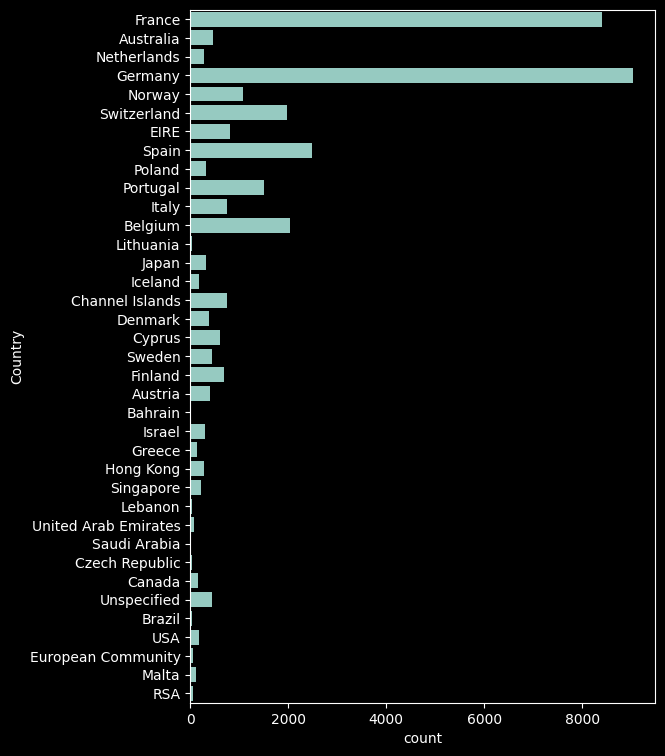

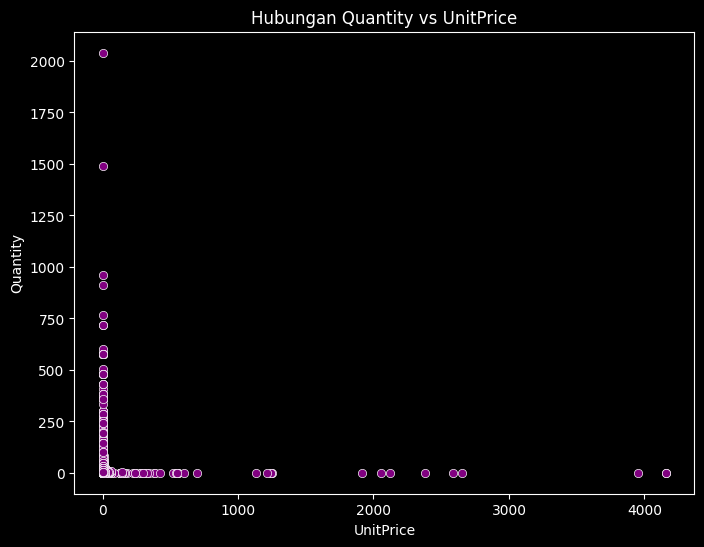

In [626]:
# Scatter plot hubungan Quantity vs UnitPrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UnitPrice', y='Quantity', data=df, color='purple')
plt.title("Hubungan Quantity vs UnitPrice")
plt.show()

## **Data Preparation**

**Data Cleaning**

In [627]:
print("Data Duplikat: ", df.duplicated().sum())

Data Duplikat:  78


In [628]:
df_noDuplicate = df.drop_duplicates()

print("Data Duplikat: ", df_noDuplicate.duplicated().sum())

Data Duplikat:  0


In [629]:
df_noDuplicate.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1404
Country           0
dtype: int64

Drop Customer id yang null

In [630]:
# Menghapus baris dengan nilai kosong
df_noNull = df_noDuplicate.dropna(subset=['CustomerID'])

# Menampilkan jumlah nilai kosong dan dimensi data setelah menghapus baris
print("Jumlah nilai null:\n", df_noNull.isnull().sum())
print("Jumlah baris dan kolom setelah drop:", df_noNull.shape)

Jumlah nilai null:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
Jumlah baris dan kolom setelah drop: (33634, 8)


Hapus data outlier

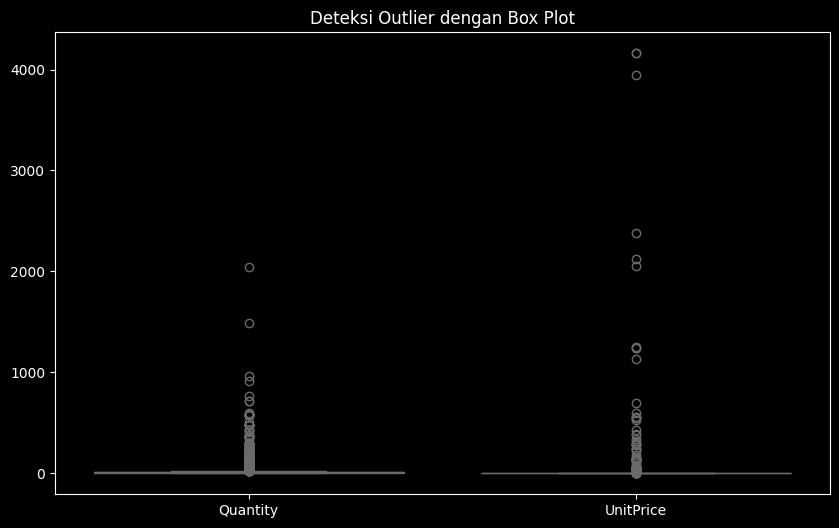

In [631]:
# Box plot untuk deteksi outlier
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_noNull[['Quantity', 'UnitPrice']], palette='Set3')
plt.title("Deteksi Outlier dengan Box Plot")
plt.show()

In [632]:
# Pisahkan kolom numerik dan non-numerik
numerical_cols = df_noNull[['Quantity', 'UnitPrice']]  # Kolom numerik yang ingin dicek
non_numerical_cols = df_noNull.drop(columns=numerical_cols.columns)  # Kolom non-numerik

# Hitung Q1, Q3, dan IQR untuk kolom numerik
Q1 = numerical_cols.quantile(0.25)
Q3 = numerical_cols.quantile(0.75)
IQR = Q3 - Q1

# Filter baris tanpa outlier pada kolom numerik
numerical_cleaned = numerical_cols[((numerical_cols < (Q1 - 1.5 * IQR)) |
                                     (numerical_cols > (Q3 + 1.5 * IQR))).any(axis=1)]

# Gabungkan kembali kolom non-numerik dengan kolom numerik yang sudah dibersihkan
df_cleaned = numerical_cleaned.join(non_numerical_cols)

# Hapus baris dengan nilai NaN (karena join bisa menghasilkan baris dengan NaN)
df_cleaned = df_cleaned.dropna()

# Tampilkan jumlah data setelah pembersihan
print("Jumlah data setelah pembersihan outliers:", df_cleaned.shape)

Jumlah data setelah pembersihan outliers: (10261, 8)


Ubah data type CustomerID dari float menjadi integer

In [633]:
# Make a copy of the DataFrame to avoid modifying the original DataFrame
df_cleaned = df_cleaned.copy()

# Convert 'CustomerID' to integers
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

# Verify the result
print(df_cleaned.CustomerID.head())

0    12583
1    12583
4    12583
5    12583
6    12583
Name: CustomerID, dtype: int64


**Transaction Level**

Menambah fitur sales

In [634]:
# Create 'Sales' interaction feature
df_cleaned['Sales'] = df_cleaned.Quantity * df_cleaned.UnitPrice

# Reset indeks dan mulai dari 0
df_cleaned = df_cleaned.reset_index(drop=True)

# Tampilkan data untuk memverifikasi
df_cleaned.head()

,Quantity,UnitPrice,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,Sales
0,24,3.75,536370,22728,ALARM CLOCK BAKELIKE PINK,12/1/10 8:45,12583,France,90.0
1,24,3.75,536370,22727,ALARM CLOCK BAKELIKE RED,12/1/10 8:45,12583,France,90.0
2,24,0.65,536370,21883,STARS GIFT TAPE,12/1/10 8:45,12583,France,15.6
3,48,0.85,536370,10002,INFLATABLE POLITICAL GLOBE,12/1/10 8:45,12583,France,40.8
4,24,1.25,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,12/1/10 8:45,12583,France,30.0


In [635]:
# Save cleaned transaction-level data
df_cleaned.to_csv('cleaned_transactions.csv', index=None)

## **Data Transformation**

**Customer Level**

Mengonversi dataset transaksi (transaction-level) menjadi dataset berbasis pelanggan (customer-level) di mana satu baris merepresentasikan satu pelanggan.

Fitur yang ingin direkayasa (engineered):

*   total_transactions: Jumlah invoice unik per pelanggan.

*   total_products: Jumlah total produk yang dibeli.

*   total_unique_products: Jumlah produk unik yang dibeli.


*   total_sales: Total penjualan per pelanggan.

*   avg_product_value:

**Agregasi Invoice Data:**

In [636]:
# Aggregate invoice data using a dictionary for renaming
invoice_data = df_cleaned.groupby('CustomerID').agg(total_transactions=('InvoiceNo', 'nunique'))

# Display invoice data for the first 5 customers
invoice_data.head()

,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,7


**Agregasi Data Produk:**

In [637]:
# Aggregate product data
product_data = df_cleaned.groupby('CustomerID').agg(total_products=('StockCode','count'), 
                                                    total_unique_products=('StockCode', 'nunique'))

# Display product data for first 5 customers
product_data.head()

,total_products,total_unique_products
CustomerID,,
12347,42,23
12348,30,21
12349,18,18
12350,2,2
12352,19,10


**Agregasi Data Penjualan:**

In [638]:
sales_data = df_cleaned.groupby('CustomerID').agg(total_sales=('Sales', 'sum'), 
                                                  avg_product_value=('Sales', 'mean'))

# Display sales data for the first 5 customers
sales_data.head()

,total_sales,avg_product_value
CustomerID,,
12347,1541.03,36.691190
12348,1780.24,59.341333
12349,799.80,44.433333
12350,60.40,30.200000
12352,1375.10,72.373684


**Invoice Level**

Menghitung Nilai Keranjang (Cart Value)

Alasan: Nilai rata-rata produk (avg_product_value) tidak memperhitungkan kelompok produk dalam "keranjang" atau invoice yang sama.

**Agregasi cart**

Hitung total penjualan per invoice

In [639]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df_cleaned.groupby(['CustomerID' , 'InvoiceNo']).agg(cart_value=('Sales','sum'))

# Display cart data for first 20 CARTS
cart_data.head(20)

cart_value
CustomerID InvoiceNo            
12347      537626         131.70
           542237         131.85
           549222         330.45
           556201          51.10
           562032         325.05
           573511         437.92
           581180         132.96
12348      539318         892.80
           541998         227.44
           548955         350.00
           568172         310.00
12349      577609         799.80
12350      543037          60.40
12352      544156          68.10
           545323          74.00
           545332         840.30
           547390          40.00
           567505         139.00
           568699          79.80
           574275         133.90

In [640]:
# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 10 CARTS
cart_data.head(10)

,CustomerID,InvoiceNo,cart_value
0,12347,537626,131.70
1,12347,542237,131.85
2,12347,549222,330.45
3,12347,556201,51.10
4,12347,562032,325.05
5,12347,573511,437.92
6,12347,581180,132.96
7,12348,539318,892.80
8,12348,541998,227.44
9,12348,548955,350.00


**Agregasi data cart berdasarkan pelanggan**

*   'avg_cart_value' - nilai cart rata-rata per pelanggan.
*   'min_cart_value' - nilai cart minimum berdasarkan pelanggan.
*   'max_cart_value' - nilai maksimum cart berdasarkan pelanggan.

In [641]:
agg_cart_data = cart_data.groupby('CustomerID').agg(
    avg_cart_value=('cart_value', 'mean'),
    min_cart_value=('cart_value', 'min'),
    max_cart_value=('cart_value', 'max')
)

# Display cart data for first 5 CUSTOMERS
agg_cart_data.head()

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,220.147143,51.10,437.92
12348,445.060000,227.44,892.80
12349,799.800000,799.80,799.80
12350,60.400000,60.40,60.40
12352,196.442857,40.00,840.30


**Join Dataframes**

Menggabungkan berbagai dataframe:
*   invoice_data
*   product_data
*   sales_data
*   agg_cart_data

In [642]:
# Join together customer-level data
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])

# Display customer-level data for first 5 customers
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,42,23,1541.03,36.691190,220.147143,51.10,437.92
12348,4,30,21,1780.24,59.341333,445.060000,227.44,892.80
12349,1,18,18,799.80,44.433333,799.800000,799.80,799.80
12350,1,2,2,60.40,30.200000,60.400000,60.40,60.40
12352,7,19,10,1375.10,72.373684,196.442857,40.00,840.30


In [643]:
customer_df.to_csv('analytical_base_table.csv')

Standarisasi Data

In [644]:
data = pd.read_csv('analytical_base_table.csv')
data.head()

,CustomerID,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
0,12347,7,42,23,1541.03,36.691190,220.147143,51.10,437.92
1,12348,4,30,21,1780.24,59.341333,445.060000,227.44,892.80
2,12349,1,18,18,799.80,44.433333,799.800000,799.80,799.80
3,12350,1,2,2,60.40,30.200000,60.400000,60.40,60.40
4,12352,7,19,10,1375.10,72.373684,196.442857,40.00,840.30


In [645]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(data.iloc[:, 1:])

## **Data Reduction**

In [646]:
pca = PCA(n_components=2)  # Reduksi ke 2 dimensi
data_pca = pca.fit_transform(x_scaled)

# Visualisasi varians yang dijelaskan oleh PCA
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Total variance explained by 2 components: {explained_variance:.2f}")

Total variance explained by 2 components: 0.78


## **K-Means Clustering**

Elbow Method

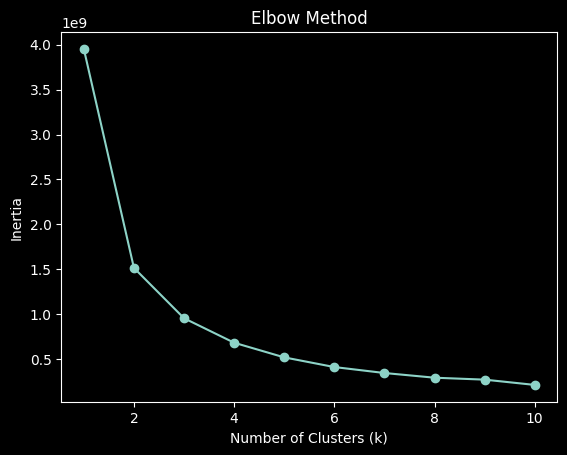

In [647]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data.iloc[:, 1:])
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

Build Model

In [648]:
k_optimal = 3 
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(data_pca) 

In [649]:
# Tambahkan hasil cluster ke dataset asli
data['Cluster'] = clusters

data.head()

,CustomerID,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,Cluster
0,12347,7,42,23,1541.03,36.691190,220.147143,51.10,437.92,1
1,12348,4,30,21,1780.24,59.341333,445.060000,227.44,892.80,1
2,12349,1,18,18,799.80,44.433333,799.800000,799.80,799.80,1
3,12350,1,2,2,60.40,30.200000,60.400000,60.40,60.40,1
4,12352,7,19,10,1375.10,72.373684,196.442857,40.00,840.30,1


In [650]:
# Jumlah pelanggan per cluster
print(data['Cluster'].value_counts())

Cluster
1    367
0     27
2     14
Name: count, dtype: int64


Labeling Cluster

In [651]:
# Statistik deskriptif tiap cluster
cluster_analysis = data.groupby('Cluster').mean()
print(cluster_analysis)

           CustomerID  total_transactions  total_products  \
Cluster                                                     
0        12824.111111           14.222222      119.703704   
1        12826.779292            2.861035       16.874659   
2        12613.000000            2.571429       59.714286   

         total_unique_products  total_sales  avg_product_value  \
Cluster                                                          
0                    69.222222  6525.630370          50.744100   
1                    13.253406   633.062779          39.558055   
2                    51.142857  8313.520000         334.367064   

         avg_cart_value  min_cart_value  max_cart_value  
Cluster                                                  
0            558.730389       94.008519     1475.640741  
1            231.408057      161.612098      328.400027  
2           3466.144204     2446.691429     4598.058571  


In [652]:
# Mapping label ke masing-masing cluster
cluster_labels = {
    0: "Loyal High-Spender",  
    1: "Occasional Shoppers",
    2: "Premium Customers"
}

# Tambahkan kolom label ke dataset
data['Customer_Segment'] = data['Cluster'].map(cluster_labels)

# Tampilkan data dengan label
data.head()

,CustomerID,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,Cluster,Customer_Segment
0,12347,7,42,23,1541.03,36.691190,220.147143,51.10,437.92,1,Occasional Shoppers
1,12348,4,30,21,1780.24,59.341333,445.060000,227.44,892.80,1,Occasional Shoppers
2,12349,1,18,18,799.80,44.433333,799.800000,799.80,799.80,1,Occasional Shoppers
3,12350,1,2,2,60.40,30.200000,60.400000,60.40,60.40,1,Occasional Shoppers
4,12352,7,19,10,1375.10,72.373684,196.442857,40.00,840.30,1,Occasional Shoppers


In [653]:
data.to_csv('hasil clustering.csv')

Evaluate the model (before tuning)

Visualisasi PCA

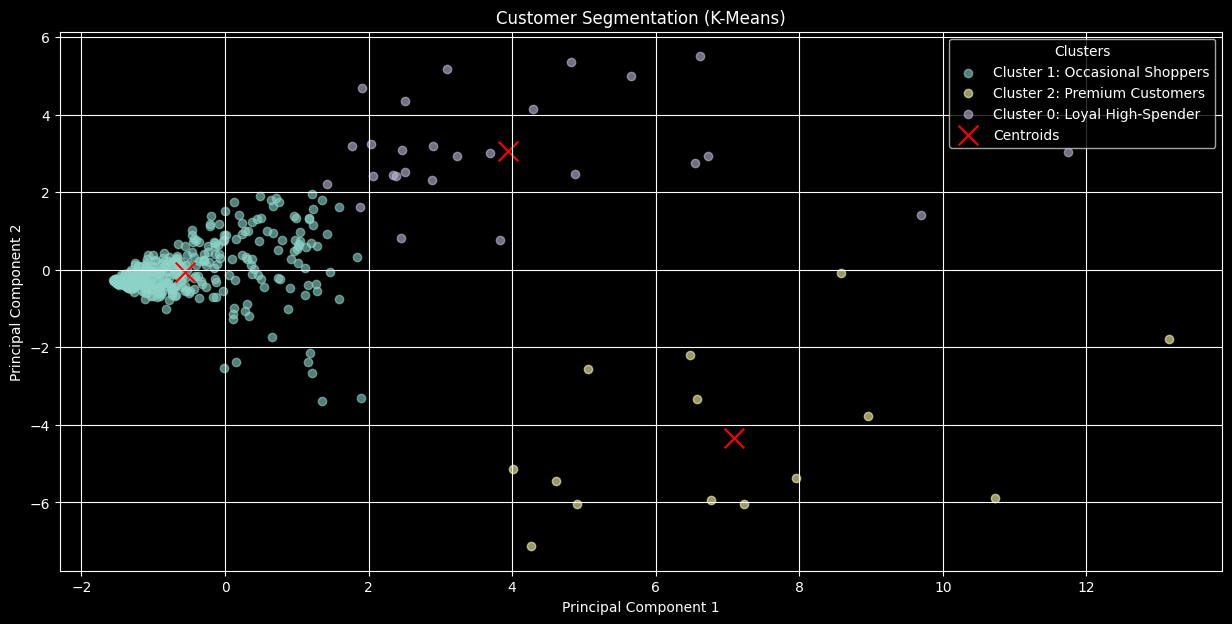

In [654]:
import matplotlib.pyplot as plt

# Scatter plot untuk visualisasi cluster
plt.figure(figsize=(15, 7))

# Iterasi untuk setiap cluster
for cluster in data["Cluster"].unique():
    cluster_points = data_pca[clusters == cluster]  # Ambil data sesuai cluster
    plt.scatter(
        cluster_points[:, 0],  # Kolom pertama PCA
        cluster_points[:, 1],  # Kolom kedua PCA
        label=f'Cluster {cluster}: {cluster_labels[cluster]}',
        alpha=0.6
    )

# Scatter plot untuk centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    color='red',
    marker='x',
    s=200,
    label='Centroids'
)

# Tambahkan judul, label, dan legenda
plt.title('Customer Segmentation (K-Means)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Clusters", loc='upper right')
plt.grid(True)
plt.show()


In [655]:
silhouette_avg = silhouette_score(data.iloc[:, 1:-1], data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.7515262397618815


## **Random Forest**

In [656]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

In [657]:
df = pd.read_csv("hasil clustering.csv")

df.head()

,Unnamed: 0,CustomerID,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,Cluster,Customer_Segment
0,0,12347,7,42,23,1541.03,36.691190,220.147143,51.10,437.92,1,Occasional Shoppers
1,1,12348,4,30,21,1780.24,59.341333,445.060000,227.44,892.80,1,Occasional Shoppers
2,2,12349,1,18,18,799.80,44.433333,799.800000,799.80,799.80,1,Occasional Shoppers
3,3,12350,1,2,2,60.40,30.200000,60.400000,60.40,60.40,1,Occasional Shoppers
4,4,12352,7,19,10,1375.10,72.373684,196.442857,40.00,840.30,1,Occasional Shoppers


Memilih Fitur

In [658]:
X = df[['total_transactions', 'total_products', 'total_unique_products', 'total_sales',
          'avg_product_value', 'avg_cart_value', 'min_cart_value', 'max_cart_value']]
y = df['Cluster']

SMOTE

In [659]:
# Menggunakan SMOTE untuk balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Menampilkan distribusi awal segmen pelanggan
print("Distribusi awal segmen pelanggan:", Counter(y))

# Cek distribusi setelah SMOTE
print("Distribusi setelah SMOTE:", Counter(y_resampled))


Distribusi awal segmen pelanggan: Counter({1: 367, 0: 27, 2: 14})
Distribusi setelah SMOTE: Counter({1: 367, 2: 367, 0: 367})


In [660]:
# Membagi data menjadi Training dan Testing set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [661]:
print(y_train.value_counts())
print(y_test.value_counts())

Cluster
0    294
1    293
2    293
Name: count, dtype: int64
Cluster
1    74
2    74
0    73
Name: count, dtype: int64


In [662]:
# Inisialisasi Random Forest Classifier
rf_model= RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model
rf_model.fit(X_train, y_train)

# Prediksi pada data testing
y_pred = rf_model.predict(X_test)

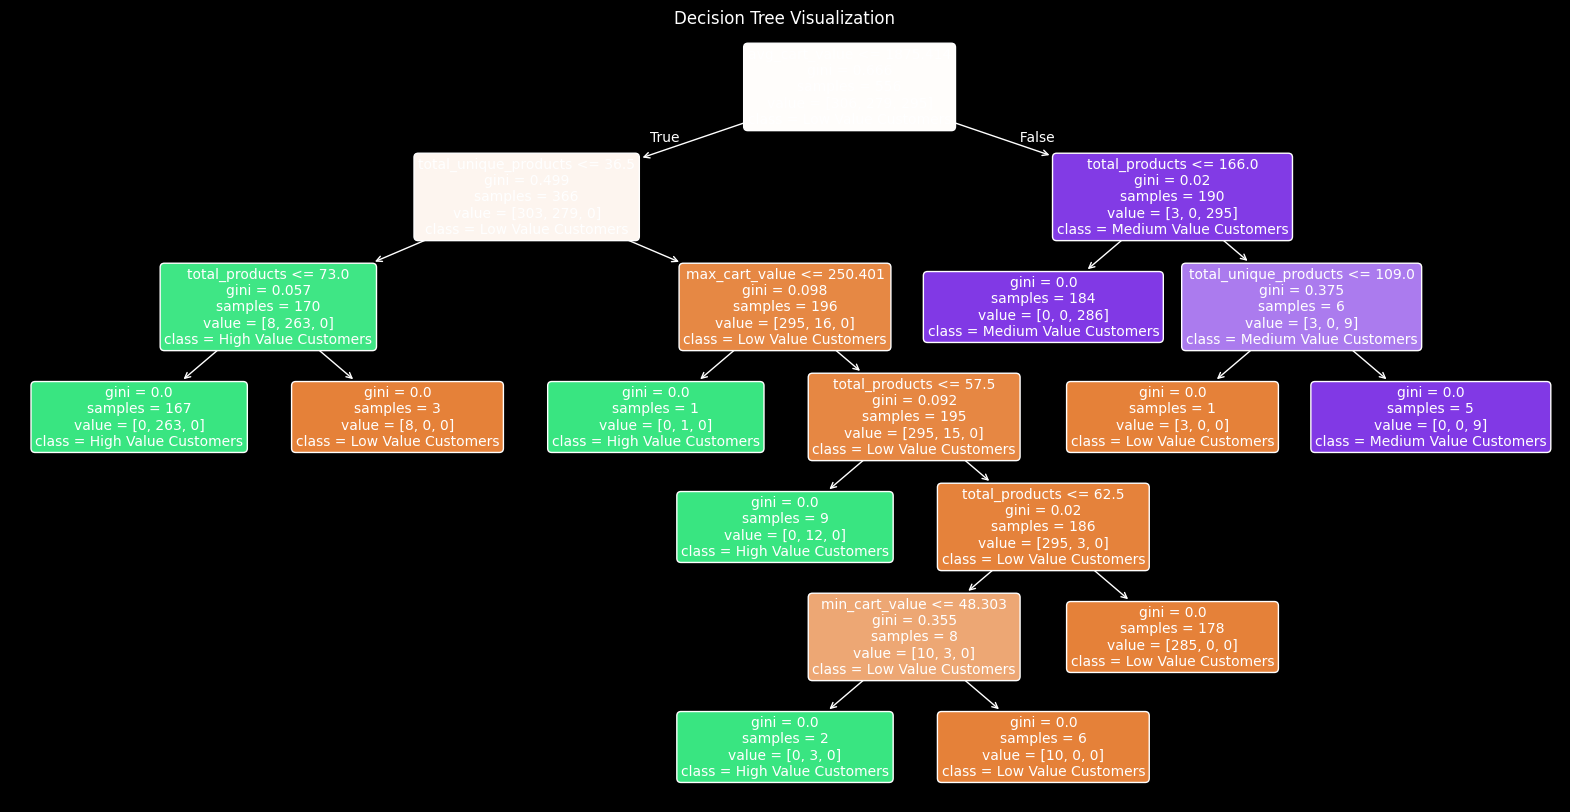

In [663]:
from sklearn import tree

# Pilih salah satu pohon dari Random Forest
dt_model = rf_model.estimators_[0]

# Visualisasi Decision Tree
plt.figure(figsize=(20, 10))
tree.plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=["Low Value Customers", "High Value Customers", "Medium Value Customers"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()


Evaluasi

In [664]:
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [665]:
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.995475113122172


In [666]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[73  0  0]
 [ 1 73  0]
 [ 0  0 74]]


In [667]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        73
           1       1.00      0.99      0.99        74
           2       1.00      1.00      1.00        74

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



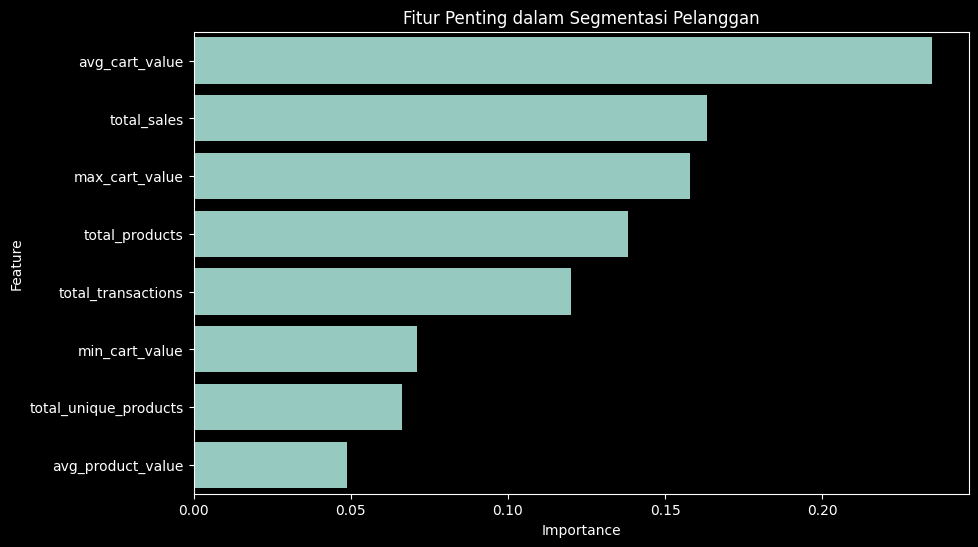

In [668]:
# Menampilkan fitur penting
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Visualisasi fitur penting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Fitur Penting dalam Segmentasi Pelanggan')
plt.show()

## **DASHBOARD**

In [669]:
import pickle

with open('rf_model.pkl','wb') as f:
    pickle.dump(rf_model, f)

In [670]:
!pip install streamlit

In [671]:
!ngrok config add-authtoken 2pbzt4Yah9as7brI61ucb0CJ4om_5JdEDcYWigLzAYSEVg7x1

Authtoken saved to configuration file: /Users/susantiafrilia/Library/Application Support/ngrok/ngrok.yml


In [672]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px

# Page Config
st.set_page_config(page_title="Data Mining", layout="wide")

# Custom CSS for Dark Theme and Enhanced Styling
st.markdown("""
<style>
    /* Dark theme background and text color */
    .stApp {
        background-color: #1E2326;
        color: #FFFFFF;
    }

    /* Header styling */
    .main-header {
        padding: 2rem 1rem;
        background-color: #2C3333;
        border-radius: 15px;
        margin-bottom: 30px;
        text-align: center;
    }
    .header-title {
        font-size: 32px;
        font-weight: bold;
        color: #FF69B4;
        margin-bottom: 10px;
    }
    .header-subtitle {
        font-size: 18px;
        color: #B0B0B0;
    }

    /* Card styling for metrics */
    .metric-card {
        background-color: #2C3333;
        padding: 20px;
        border-radius: 15px;
        text-align: center;
        transition: transform 0.2s;
    }
    .metric-card:hover {
        transform: scale(1.05);
    }
    .metric-value {
        font-size: 28px;
        font-weight: bold;
        color: #FF69B4;
    }
    .metric-label {
        color: #B0B0B0;
        font-size: 16px;
    }

    /* Hide Streamlit branding */
    #MainMenu {visibility: hidden;}
    footer {visibility: hidden;}

    /* Filter section */
    .filters-section {
        background-color: #2C3333;
        padding: 15px;
        border-radius: 15px;
        margin-bottom: 30px;
    }

    /* Button styling */
    .stButton>button {
        background-color: #FF69B4;
        color: white;
        border-radius: 10px;
        padding: 10px 24px;
        font-size: 16px;
    }
    .stButton>button:hover {
        background-color: #FF85C1;
    }

</style>
""", unsafe_allow_html=True)

# Header Section with Enhanced Styling
st.markdown("""
<div class="main-header">
    <div class="header-title">SEGMENTASI DAN KLASIFIKASI PELANGGAN</div>
    <div class="header-subtitle">Kelompok 6 SI4609</div>
</div>
""", unsafe_allow_html=True)

# Load Data with Caching for Performance
@st.cache_data
def load_data():
    data_path = "cleaned_transactions.csv"
    data = pd.read_csv(data_path, parse_dates=['InvoiceDate'])  # Ensure date parsing
    return data

data = load_data()

# Sidebar for Filters (Enhancing User Control)
st.sidebar.header("Filters")
selected_country = st.sidebar.selectbox("Select Country", options=["All"] + sorted(data["Country"].unique()))

# Filter Data Based on User Selections
filtered_data = data.copy()
if selected_country != "All":
    filtered_data = filtered_data[filtered_data["Country"] == selected_country]

# Key Metrics Displayed as Cards
st.markdown("### Key Metrics")
metric1, metric2, metric3, metric4 = st.columns(4)

with metric1:
    unique_customers = filtered_data["CustomerID"].nunique()
    st.markdown(f"""
    <div class="metric-card">
        <div class="metric-value">{unique_customers:,}</div>
        <div class="metric-label">Unique Customers</div>
    </div>
    """, unsafe_allow_html=True)

with metric2:
    unique_invoices = filtered_data["InvoiceNo"].nunique()
    st.markdown(f"""
    <div class="metric-card">
        <div class="metric-value">{unique_invoices:,}</div>
        <div class="metric-label">Total Invoices</div>
    </div>
    """, unsafe_allow_html=True)

with metric3:
    unique_products = filtered_data["StockCode"].nunique()
    st.markdown(f"""
    <div class="metric-card">
        <div class="metric-value">{unique_products:,}</div>
        <div class="metric-label">Unique Products</div>
    </div>
    """, unsafe_allow_html=True)

with metric4:
    total_sales = filtered_data['Sales'].sum()
    st.markdown(f"""
    <div class="metric-card">
        <div class="metric-value">${total_sales:,.2f}</div>
        <div class="metric-label">Total Sales</div>
    </div>
    """, unsafe_allow_html=True)

# Charts Section with Enhanced Visuals and Interactivity
st.markdown("### Data Visualizations")
chart1, chart2 = st.columns(2)

with chart1:
    st.markdown("#### Sales Over Time")
    sales_over_time = filtered_data.set_index('InvoiceDate').resample('M')['Sales'].sum().reset_index()
    fig = px.line(sales_over_time, x='InvoiceDate', y='Sales', 
                  title='Monthly Sales',
                  labels={'InvoiceDate': 'Date', 'Sales': 'Sales ($)'},
                  template='plotly_dark')
    fig.update_traces(line=dict(color='#FF69B4'))
    fig.update_layout(showlegend=False)
    st.plotly_chart(fig, use_container_width=True)
    st.markdown('</div>', unsafe_allow_html=True)

with chart2:
    st.markdown("#### Top 10 Products by Sales")
    top_products = filtered_data.groupby('StockCode')['Sales'].sum().nlargest(10).reset_index()
    fig = px.bar(top_products, x='StockCode', y='Sales',
                 title='Top 10 Products',
                 labels={'StockCode': 'Product Code', 'Sales': 'Sales ($)'},
                 template='plotly_dark',
                 color='Sales',
                 color_continuous_scale='RdBu')
    st.plotly_chart(fig, use_container_width=True)
    st.markdown('</div>', unsafe_allow_html=True)

insight1 = st.container()

with insight1:
    st.markdown("#### Sales by Country")
    sales_country = filtered_data.groupby('Country')['Sales'].sum().reset_index()
    fig = px.choropleth(sales_country, locations='Country',
                        locationmode='country names',
                        color='Sales',
                        hover_name='Country',
                        color_continuous_scale='RdBu',
                        title='Global Sales Distribution',
                        template='plotly_dark')
    st.plotly_chart(fig, use_container_width=True)
    st.markdown('</div>', unsafe_allow_html=True)

# Data Table with Enhanced Styling and Pagination
st.markdown("### Detailed Data Table")
st.markdown('<div>', unsafe_allow_html=True)
st.dataframe(filtered_data.reset_index(drop=True).style.set_properties(**{
    'background-color': '#2C3333',
    'color': 'white',
    'border-color': '#2C3333',
    'font-size': '14px'
}))
st.markdown('</div>', unsafe_allow_html=True)

# Footer Section
st.markdown("""
<div style="text-align: center; color: #B0B0B0; padding: 20px;">
    &copy; 2024 Kelompok 6 / SI4609 | All Rights Reserved
</div>
""", unsafe_allow_html=True)


Overwriting app.py


In [673]:
df = pd.read_csv('cleaned_transactions.csv')
print(df.columns)  # Menampilkan semua kolom yang ada di dataset


Index(['Quantity', 'UnitPrice', 'InvoiceNo', 'StockCode', 'Description',
       'InvoiceDate', 'CustomerID', 'Country', 'Sales'],
      dtype='object')


In [674]:
from pyngrok import ngrok
import threading
import os

In [675]:
# Jalankan Streamlit di thread terpisah
# Ekspos Streamlit ke internet menggunakan Ngrok
from pyngrok import ngrok
import threading
import os

def run_streamlit():
    os.system("streamlit run app.py --server.port 8501")

thread = threading.Thread(target=run_streamlit)
thread.start()

public_url = ngrok.connect(addr="8501")
print(f"Streamlit app is live at {public_url}")

Streamlit app is live at NgrokTunnel: "https://b618-125-164-22-131.ngrok-free.app" -> "http://localhost:8501"


/Users/susantiafrilia/Downloads/TUBES DATMIN 2/app.py:156: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/Users/susantiafrilia/Downloads/TUBES DATMIN 2/app.py:156: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

